<a href="https://colab.research.google.com/github/Ujwal345/FMML_Project_and_Labs/blob/main/Mod7_Project_ipynb_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ujwal Dhomne**

Module 7 Project: Movie Recommendation Engine



In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-03-31 14:24:28--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.52MB/s    in 0.6s    

2024-03-31 14:24:29 (1.52 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


Romance versus Science Fiction

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


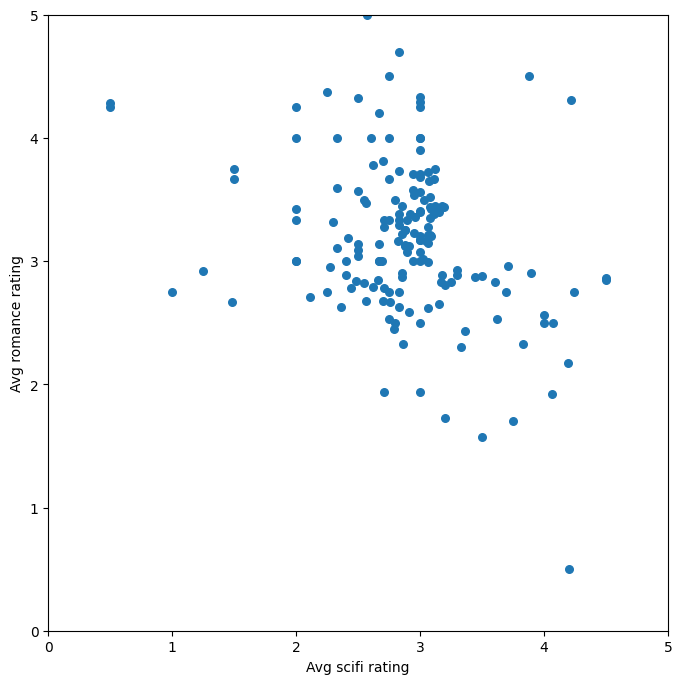

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


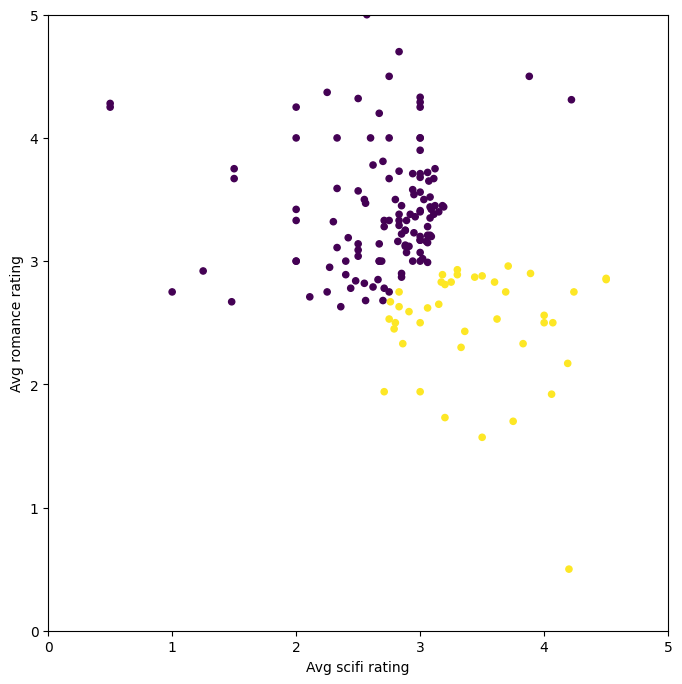

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


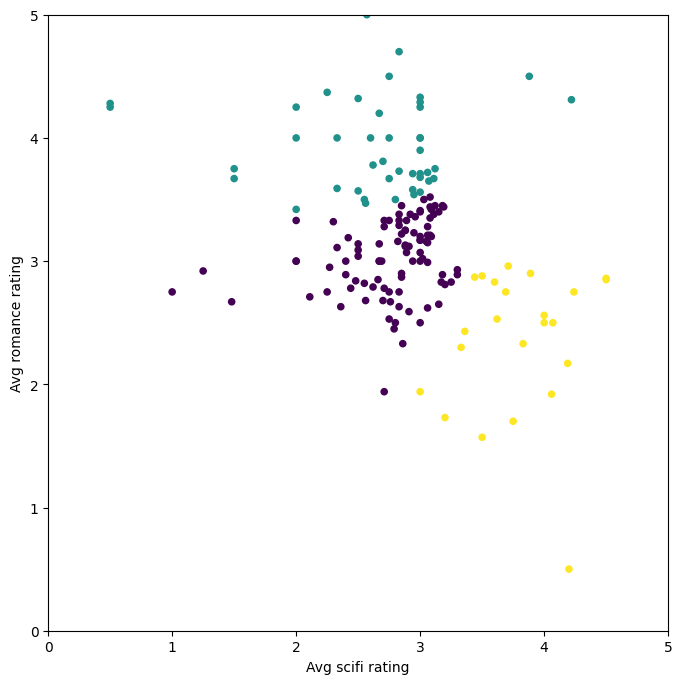

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

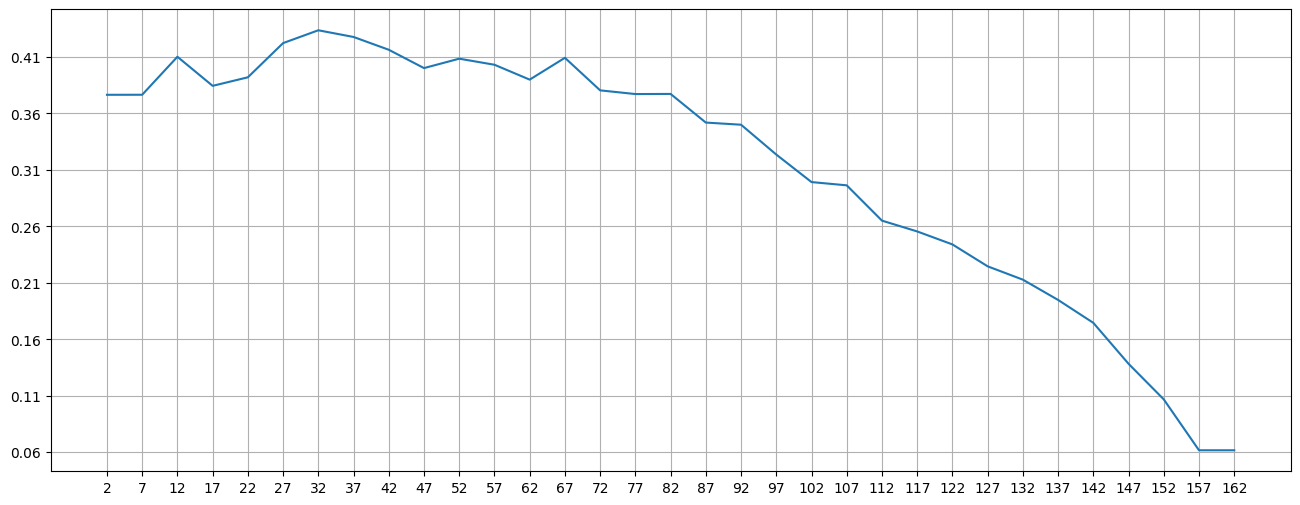

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


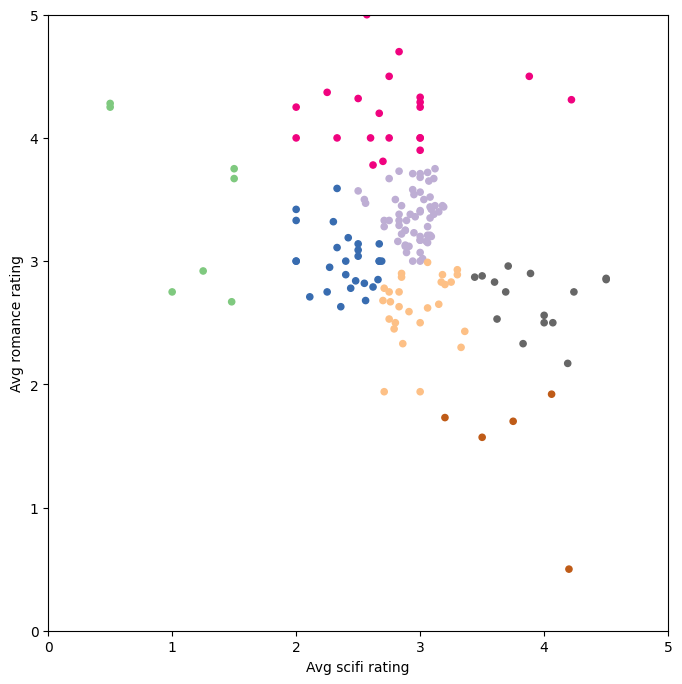

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


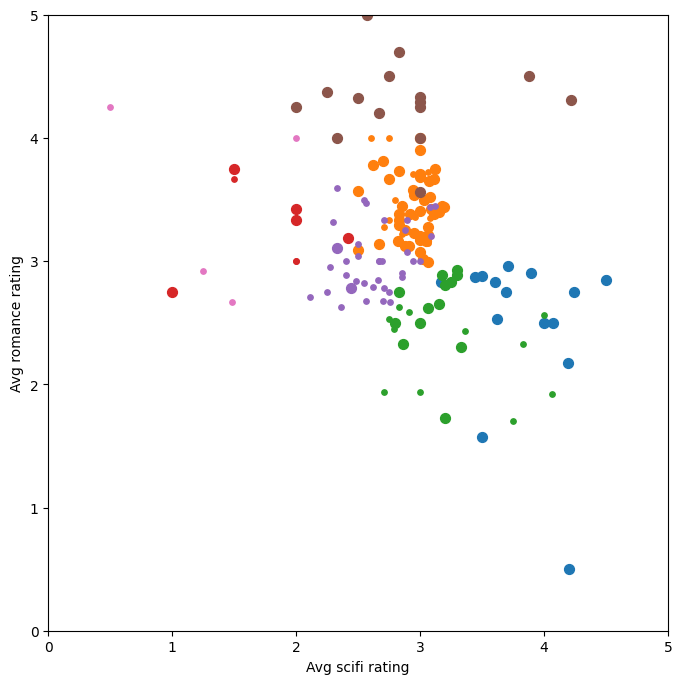

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

Exercise 1

Instead of choosing a n_clusters as 7, play around with different k Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method



In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

# Impute NaN values in genre_ratings
imputer = SimpleImputer(strategy='mean')
genre_ratings_imputed = imputer.fit_transform(genre_ratings)

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(genre_ratings_imputed)
    score = silhouette_score(genre_ratings_imputed, kmeans.labels_)
    silhouette_scores.append(score)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f'Optimal number of clusters: {optimal_clusters}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the user who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
# print(most_rated_movies_users_selection)
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
413                    5.0                               5.0   
589                    5.0                               4.5   
473                    3.0                               5.0   
479                    5.0                               5.0   
67                     3.5                               3.0   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
413                    5.0                               4.0   
589                    4.5                               3.5   
473                    4.0                               4.5   
479                    4.0                               4.5   
67                     2.0                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
413                   5.0                                        5.0   
589                   4.0                               

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


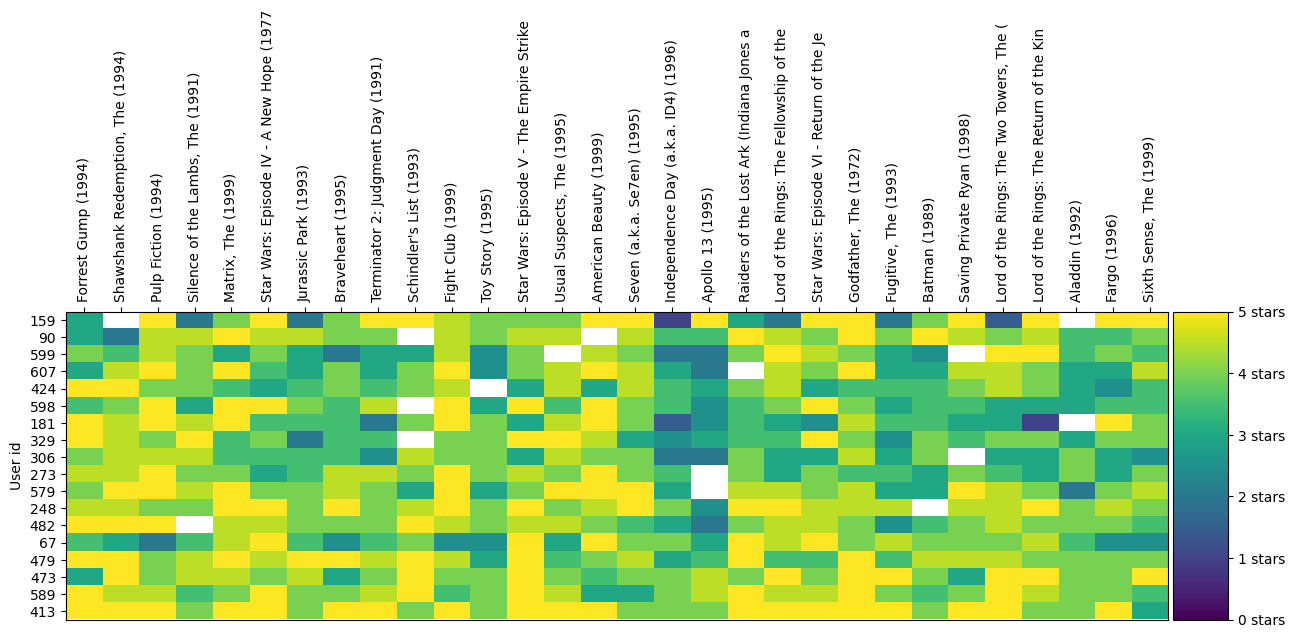

In [18]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [19]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


In [20]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

Large Scale Clustering

In [21]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
# Cluster and print some of them
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# draw_movie_clusters(clustered, max_users, max_movies)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


Predictions and Recommendation

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
366                  5.0                               5.0   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
366                  NaN                               5.0   

     Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
366                 NaN                                        5.0   

     Jurassic Park (1993)  Braveheart (1995)  \
366                   NaN                NaN   

     Terminator 2: Judgment Day (1991)  Schindler's List (1993)  ...  \
366                                NaN                      3.0  ...   

     Scary Movie 2 (2001)  About Schmidt (2002)  21 Jump Street (2012)  \
366                   NaN                   NaN                    NaN   

     Cider House Rules, The (1999)  Death Proof (2007)  Moonraker (1979)  \
366                            NaN                 NaN               NaN   

     Virgin Suicides, The (1999)  ¡Three Amigos! (1986)  \
366   

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


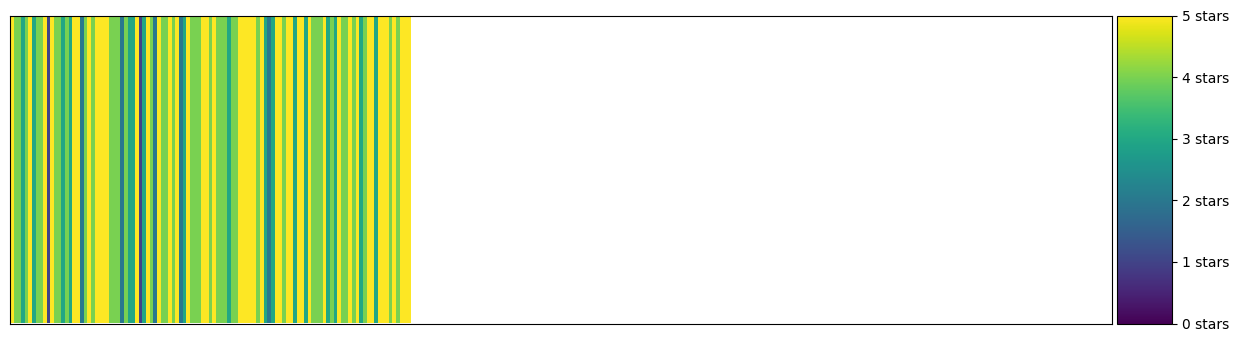

In [22]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.5

In [25]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Forrest Gump (1994)                            5.0
Mission: Impossible II (2000)                  4.0
Jaws (1975)                                    4.0
Meet the Parents (2000)                        3.0
Sabrina (1954)                                 4.0
Dead Poets Society (1989)                      5.0
When Harry Met Sally... (1989)                 3.0
Psycho (1960)                                  4.0
City Slickers (1991)                           4.0
Chicken Run (2000)                             5.0
South Park: Bigger, Longer and Uncut (1999)    1.0
Ghostbusters (a.k.a. Ghost Busters) (1984)     5.0
Dave (1993)                                    4.0
Galaxy Quest (1999)                            4.0
Liar Liar (1997)                               3.0
Unbreakable (2000)                             4.0
Charlie's Angels (2000)                        3.0
Mary Poppins (1964)                            5.0
Citizen Kane (1941)                            5.0
Young Frankenstein (1974)      

In [26]:
cluster

,Forrest Gump (1994),Mission: Impossible II (2000),Jaws (1975),Meet the Parents (2000),Sabrina (1954),Dead Poets Society (1989),When Harry Met Sally... (1989),Psycho (1960),City Slickers (1991),Chicken Run (2000),...,"World Is Not Enough, The (1999)",Bend It Like Beckham (2002),Willow (1988),Monty Python's The Meaning of Life (1983),"Hudsucker Proxy, The (1994)",Heathers (1989),Big Hero 6 (2014),Striptease (1996),"Cider House Rules, The (1999)",Hellboy (2004)
0,5.0,4.0,4.0,3.0,4.0,5.0,3.0,4.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Using Collaborative Filtering (With fast.ai)

In [27]:
! [ -e /content ] && pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.0 MB/s eta 0:00:00


In [28]:
from fastai.tabular.all import *
from fastai.collab import *

Training a model

In [29]:
path = untar_data(URLs.ML_100k)

In [30]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [31]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [32]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [33]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [34]:
dls.show_batch()

,user,title,rating
0,451,"Assignment, The (1997)",2
1,49,Batman Returns (1992),3
2,43,From Dusk Till Dawn (1996),3
3,863,187 (1997),2
4,655,Midnight in the Garden of Good and Evil (1997),2
5,835,Jerry Maguire (1996),4
6,379,Gandhi (1982),3
7,339,Dead Man Walking (1995),5
8,393,"Lawnmower Man, The (1992)",3
9,404,Mad City (1997),1


In [35]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [36]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.956757,0.948328,00:27
1,0.875762,0.855176,00:32
2,0.735780,0.818815,00:22
3,0.594953,0.804762,00:18
4,0.499892,0.805255,00:15


Interpretation

In [37]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

Movie bias

In [38]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [39]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [40]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3150),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3143),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2917), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2788), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2584), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2515), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2424), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2399), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2249), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2201), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2193), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2185), 'Beverly Hillbillies, The (1993)', 2.25),
 (tensor(-0.2169), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.2136), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2136), 'Ju

In [41]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6375), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5753), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5292), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5254), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5144), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5086), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5065), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5063), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4943), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4727), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4562), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4403), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4324), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4274), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4215), 'Vertigo (1958)', 4.251396648044692)]

Movie weights

In [42]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [43]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [44]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [45]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3131), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.2234), 'Congo (1995)'),
 (tensor(1.1810), 'Jungle2Jungle (1997)'),
 (tensor(1.1053), "McHale's Navy (1997)"),
 (tensor(1.0965), 'Flipper (1996)'),
 (tensor(1.0882), 'Bio-Dome (1996)'),
 (tensor(1.0814), 'Halloween: The Curse of Michael Myers (1995)'),
 (tensor(1.0784), 'Cutthroat Island (1995)'),
 (tensor(1.0779), 'Batman & Robin (1997)'),
 (tensor(1.0670), 'D3: The Mighty Ducks (1996)')]

In [46]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1842), 'Close Shave, A (1995)'),
 (tensor(-1.1396), 'Chinatown (1974)'),
 (tensor(-1.1382), 'Wrong Trousers, The (1993)'),
 (tensor(-1.1212), '12 Angry Men (1957)'),
 (tensor(-1.1165), 'Casablanca (1942)'),
 (tensor(-1.0750), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0629), 'Third Man, The (1949)'),
 (tensor(-1.0530), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(-1.0314), 'Ran (1985)'),
 (tensor(-1.0269), "One Flew Over the Cuckoo's Nest (1975)")]

In [47]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1178), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.1146), 'Braveheart (1995)'),
 (tensor(0.9440), 'Titanic (1997)'),
 (tensor(0.9036), 'Independence Day (ID4) (1996)'),
 (tensor(0.8879), 'Hunt for Red October, The (1990)'),
 (tensor(0.8825), 'American President, The (1995)'),
 (tensor(0.8571), 'Pretty Woman (1990)'),
 (tensor(0.8484), 'Forrest Gump (1994)'),
 (tensor(0.8191), 'Miracle on 34th Street (1994)'),
 (tensor(0.8108), 'Lion King, The (1994)')]

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9682), 'Serial Mom (1994)'),
 (tensor(-0.9217), 'Brazil (1985)'),
 (tensor(-0.8964), 'Trainspotting (1996)'),
 (tensor(-0.8907), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.8843), 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (tensor(-0.8700), 'Cable Guy, The (1996)'),
 (tensor(-0.8611), 'Dracula: Dead and Loving It (1995)'),
 (tensor(-0.8360), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8355), 'Lost Highway (1997)'),
 (tensor(-0.8073), 'To Die For (1995)')]

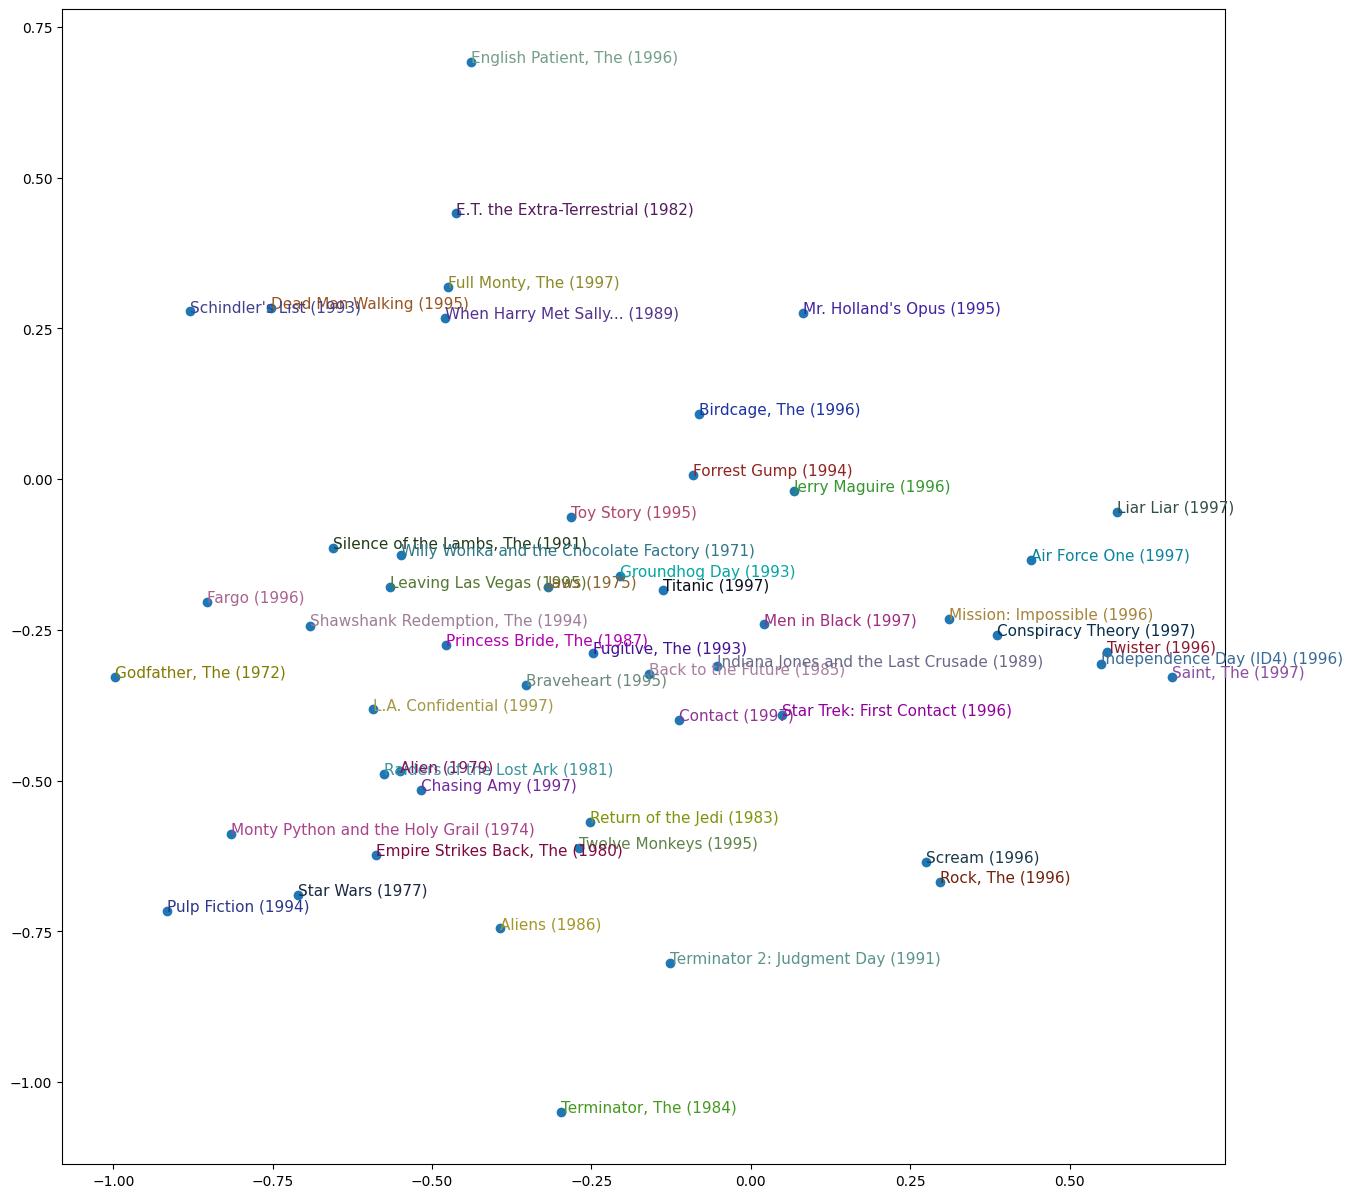

In [50]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Exercise 2

Play around with different collaborative filtering model parameters such as n_factors and other parameters.

Identify if any such parameters have impact on the speed of convergence or the performance on the model

Answer 2)

Exploring different parameters in collaborative filtering models can indeed impact both the speed of convergence and the performance of the model. Here are some common parameters to consider, along with their potential impact:

1)n_factors: This parameter determines the dimensionality of the latent factors used to represent users and items. Increasing n_factors can lead to a more expressive model but may also increase computational complexity and training time.

2)learning_rate: The learning rate controls the step size during optimization. A higher learning rate can lead to faster convergence but may also cause overshooting or instability. Conversely, a lower learning rate can lead to more stable training but may require more iterations to converge.

3)number of iterations/epochs: The number of iterations or epochs determines how many times the model will loop over the entire dataset during training. Increasing the number of iterations can improve performance up to a certain point, but may also lead to overfitting or longer training times.

4)regularization parameters (e.g., reg_all, reg_pu, reg_qi): Regularization helps prevent overfitting by penalizing large parameter values. Tuning the regularization parameters can help control model complexity and improve generalization performance.

5)biased vs. unbiased models: Some collaborative filtering models include bias terms to account for user and item biases. These biases can affect both the speed of convergence and the model's performance. Biased models may converge faster but can also be more prone to overfitting.

6)optimization algorithm (e.g., SGD, ALS): Different optimization algorithms can have varying effects on convergence speed and model performance. For example, stochastic gradient descent (SGD) may converge faster but can be sensitive to hyperparameters, while alternating least squares (ALS) tends to be more stable but may require more computational resources.

To identify the impact of these parameters on the model, you can perform experiments where you systematically vary one parameter while keeping others constant and observe the effects on convergence speed and performance metrics such as accuracy or RMSE (Root Mean Square Error) on a validation set. You can use techniques such as grid search or random search to efficiently explore the parameter space and find the optimal combination of parameters for your specific task and dataset. Additionally, monitoring training/validation loss or metrics over epochs can help assess convergence speed and detect potential issues such as overfitting or underfitting.

